In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from src.fill_nan import fill_nan_by_knn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
import sklearn.metrics as sklm
from sklearn.ensemble import VotingRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

import math

In [2]:
train_df = pd.read_csv("train_house_price.csv")
test_df = pd.read_csv("test_house_price.csv")

## 程式碼目的

這段程式碼的目的是繪製數據集中數值型特徵的相關性熱點圖，以顯示它們與目標變量 "SalePrice" 之間的相關性。同時，它還進行了篩選，找到相對於 "SalePrice" 相關性小於0.3的特徵。

## 程式執行步驟

1. **相關性熱點圖繪製：** 計算並繪製數據集中數值型特徵的相關性熱點圖。這有助於可視化這些特徵與目標變量的相關性。

2. **相關性小於0.3的特徵選擇：** 找出相對於 "SalePrice" 相關性小於0.3的特徵。

3. **特徵刪除：** 將相關性小於0.3的特徵從數據集中刪除。這有助於篩選出對目標變量相關性較高的特徵。

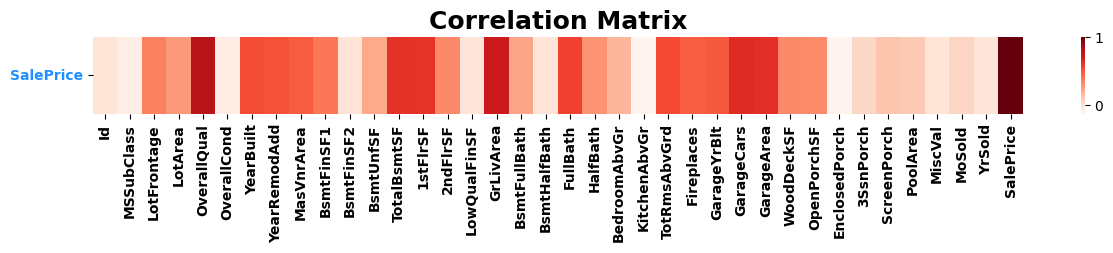

In [3]:
# 相關性熱點圖
num_data_train = train_df.select_dtypes(include=['int', 'float'])

# 計算相關性
num_corr = num_data_train.corr()

# 調整圖形大小
fig, ax = plt.subplots(figsize=(15, 1))

# 繪製相關性熱點圖
sns.heatmap(num_corr.sort_values(
    by=['SalePrice'], ascending=False).head(1), cmap='Reds')

# 設置標題和軸標籤
plt.title("Correlation Matrix", weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

# 找出相關性小於0.3的特徵
low_corr_features = num_corr['SalePrice'][num_corr['SalePrice'] < 0.3].index

# 刪除相關性小於0.3的特徵
train_df = train_df.drop(low_corr_features, axis=1)

## 程式碼目的

這段程式碼的目的是對數據集中的數值型特徵進行極端值處理。

## 程式執行步驟

1. **選擇數值型特徵：** 首先，程式碼選擇了數值型特徵，這些特徵通常包含連續數值。

2. **常態分佈檢測：** 使用 Shapiro-Wilk 測試確定哪些特徵屬於常態分佈。Shapiro-Wilk 測試用於檢測樣本數據是否來自正態分佈。

3. **極端值處理：** 對於屬於常態分佈的特徵，程式碼刪除這些特徵中95%區間外的值。這麼做的目的是處理極端值，提高模型對數據的準確性。

In [4]:
# 極端值處理
num_train_data = train_df.select_dtypes(include=['int', 'float'])

# 找出常態分佈的features
normal_distributed_features = []
for feature in num_train_data:
    stat, p_value = shapiro(train_df[feature])
    if p_value > 0.05:
        normal_distributed_features.append(feature)

# 刪除於常態分佈features中95%區間外的值
for feature in normal_distributed_features:
    mean_val = train_df[feature].mean()
    std_val = train_df[feature].std()
    lower_bound = mean_val - 1.96 * std_val
    upper_bound = mean_val + 1.96 * std_val

    # 刪除超出區間的值
    clean_train_df = train_df[(train_df[feature] >= lower_bound) & (
        train_df[feature] <= upper_bound)]

In [5]:
SalePrice_train = clean_train_df["SalePrice"]

In [6]:
# 合併，但不包含SalePrice
data = pd.concat([clean_train_df, test_df], axis=0,
                 ignore_index=True, join='inner')

## 程式碼目的

這段程式碼的目的是進行遺漏值確認，主要包括以下步驟：

## 程式執行步驟

1. **計算遺漏率：** 程式碼首先計算每個特徵的遺漏率，這表示每個特徵中缺失值的比例。

2. **條形圖呈現：** 接著，將遺漏率不為零的特徵以條形圖的形式呈現。這有助於直觀地了解哪些特徵存在遺漏值，並能夠快速了解它們的遺漏程度。

3. **刪除有過多缺失值的特徵：** 程式碼可能會根據遺漏程度刪除有過多缺失值的特徵。這麼做的目的是保證數據質量，避免模型受到缺失值的干擾。

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'PoolQC'),
  Text(1, 0, 'MiscFeature'),
  Text(2, 0, 'Alley'),
  Text(3, 0, 'Fence'),
  Text(4, 0, 'MasVnrType'),
  Text(5, 0, 'FireplaceQu'),
  Text(6, 0, 'LotFrontage'),
  Text(7, 0, 'GarageYrBlt'),
  Text(8, 0, 'GarageCond'),
  Text(9, 0, 'GarageQual'),
  Text(10, 0, 'GarageFinish'),
  Text(11, 0, 'GarageType'),
  Text(12, 0, 'BsmtExposure'),
  Text(13, 0, 'BsmtCond'),
  Text(14, 0, 'BsmtQual'),
  Text(15, 0, 'BsmtFinType2'),
  Text(16, 0, 'BsmtFinType1'),
  Text(17, 0, 'MasVnrArea'),
  Text(18, 0, 'MSZoning'),
  Text(19, 0, 'Functional'),
  Text(20, 0, 'Utilities'),
  Text(21, 0, 'GarageCars'),
  Text(22, 0, 'KitchenQual'),
  Text(23, 0, 'Electrical'),
  Text(24, 0, 'TotalBsmtSF'),
  Text(25, 0, 'GarageArea'),
  Text(26, 0, 'SaleType'),
  Text(27, 0, 'BsmtFinSF1'),
  Text(28, 0, 'Exterior2nd'),
  Text

C:\Users\d\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 36986 (\N{CJK UNIFIED IDEOGRAPH-907A}) missing from current font.
  func(*args, **kwargs)
C:\Users\d\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 28431 (\N{CJK UNIFIED IDEOGRAPH-6F0F}) missing from current font.
  func(*args, **kwargs)
C:\Users\d\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  func(*args, **kwargs)
C:\Users\d\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  func(*args, **kwargs)
C:\Users\d\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from current font.
  func(*args, **kwargs)
C:\Users\d\AppData\Roaming\Pyt

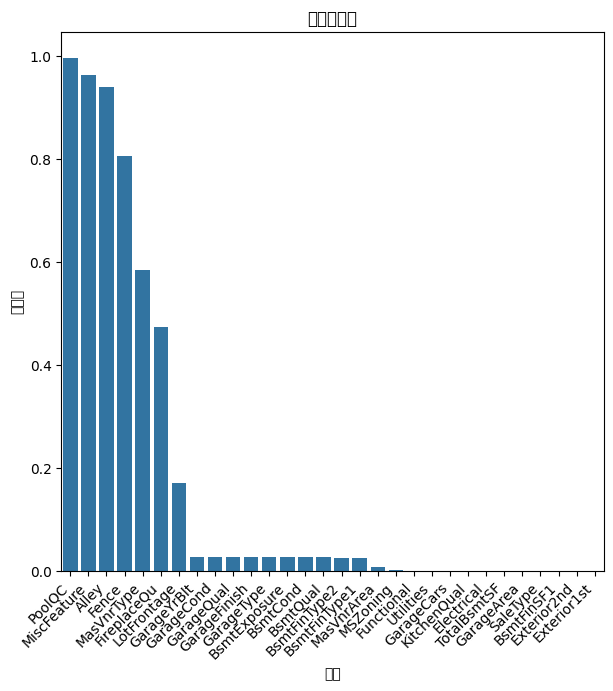

In [7]:
# 遺漏值確認
missing_columns = data.isnull().mean().sort_values(ascending=False)
missing_columns = missing_columns[missing_columns !=
                                  0].to_frame().reset_index()

# 遺漏率繪圖
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='index', y=0, data=missing_columns)
ax.set(xlabel='特徵', ylabel='遺漏率', title='特徵遺漏率')
plt.xticks(rotation=45, ha="right")

In [8]:
# 刪除有過多缺失值的col 及 id, saleprice col
data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

這段程式碼將類別型特徵的分佈以直方圖的形式排列，方便觀察每個特徵的資料分佈狀況。

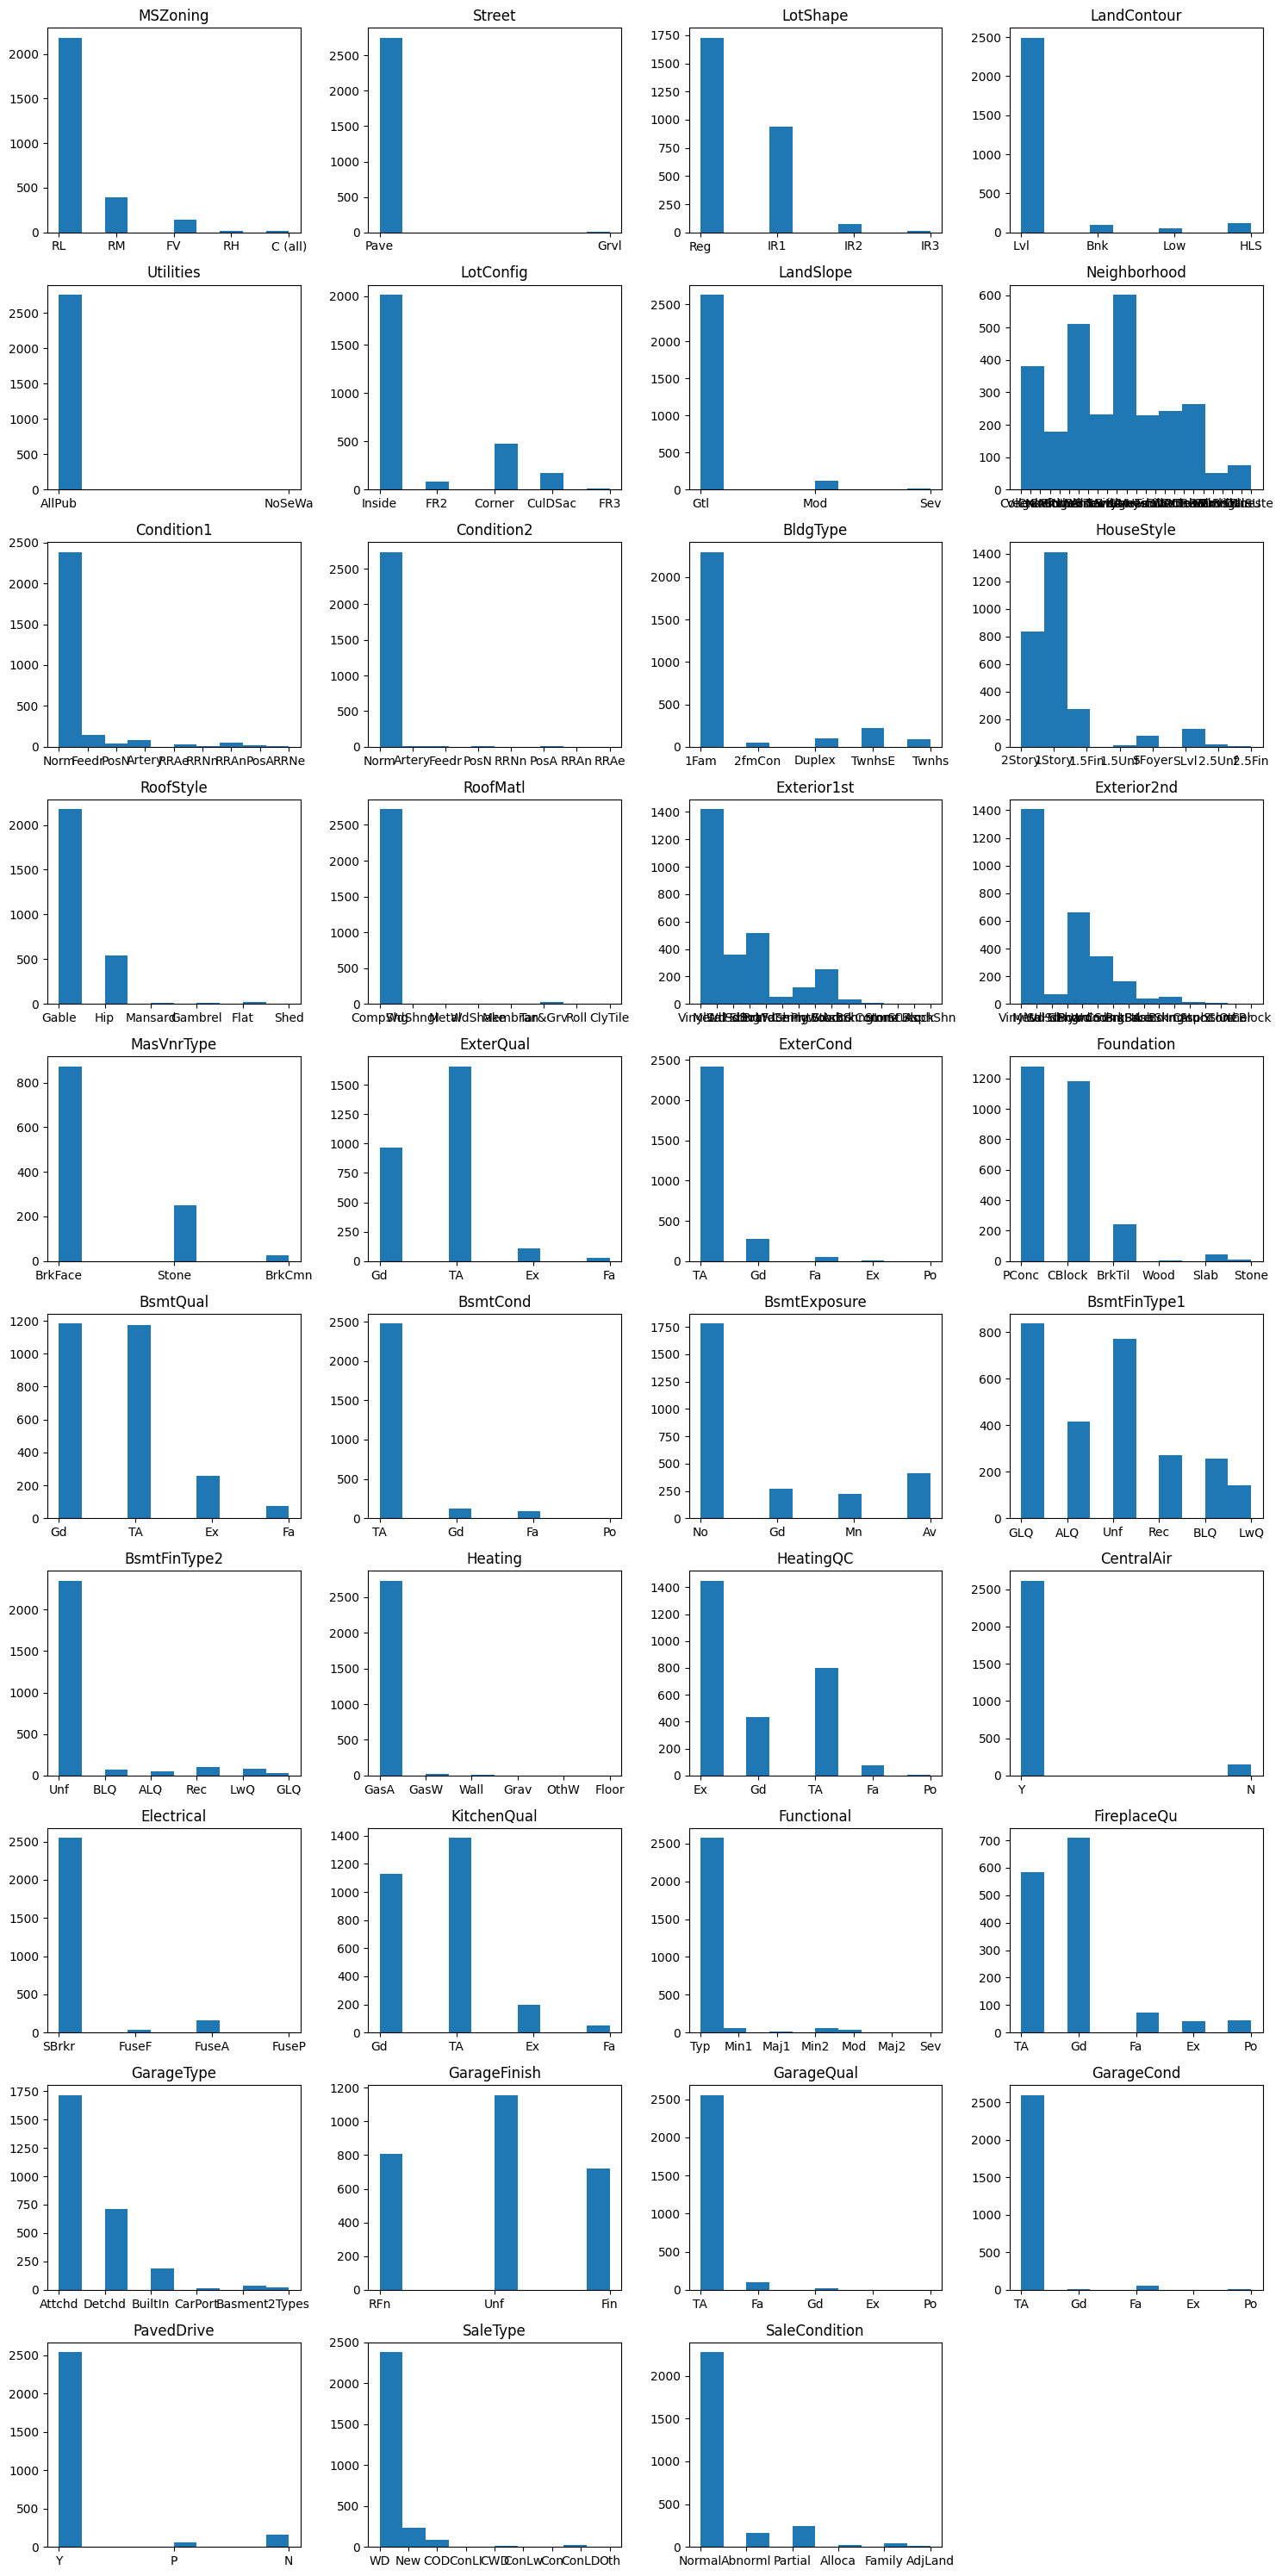

In [9]:
# 觀察object_data
object_data = data.select_dtypes(include=['object'])
num_cols_per_row = 4

# 計算總行數
num_rows = (len(object_data.columns) // num_cols_per_row) + 1

# 設置 subplot
fig, axes = plt.subplots(num_rows, num_cols_per_row,
                         figsize=(15, 3 * num_rows))

# 平坦化二維陣列
axes = axes.flatten()

# 迭代列並繪製直方圖
for i, column in enumerate(object_data.columns):
    ax = axes[i]
    ax.hist(object_data[column].dropna())
    ax.set_title(column, fontsize=12, color='black')

# 關閉多餘的子圖
for j in range(len(object_data.columns), len(axes)):
    fig.delaxes(axes[j])

# 調整子圖的間距
plt.tight_layout()

# 顯示圖表
plt.show()

In [10]:
# 刪除集中單一類別的 ob_features
data.drop(["Street", "Utilities", "LandSlope", "Condition2",
          "RoofMatl", "Heating", "Functional"], axis=1, inplace=True)

目的在於可視化數值型特徵的分佈情況

C:\Users\d\AppData\Local\Temp\ipykernel_7856\1798975225.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_data[column].dropna(), ax=axes[i])
C:\Users\d\AppData\Local\Temp\ipykernel_7856\1798975225.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_data[column].dropna(), ax=axes[i])


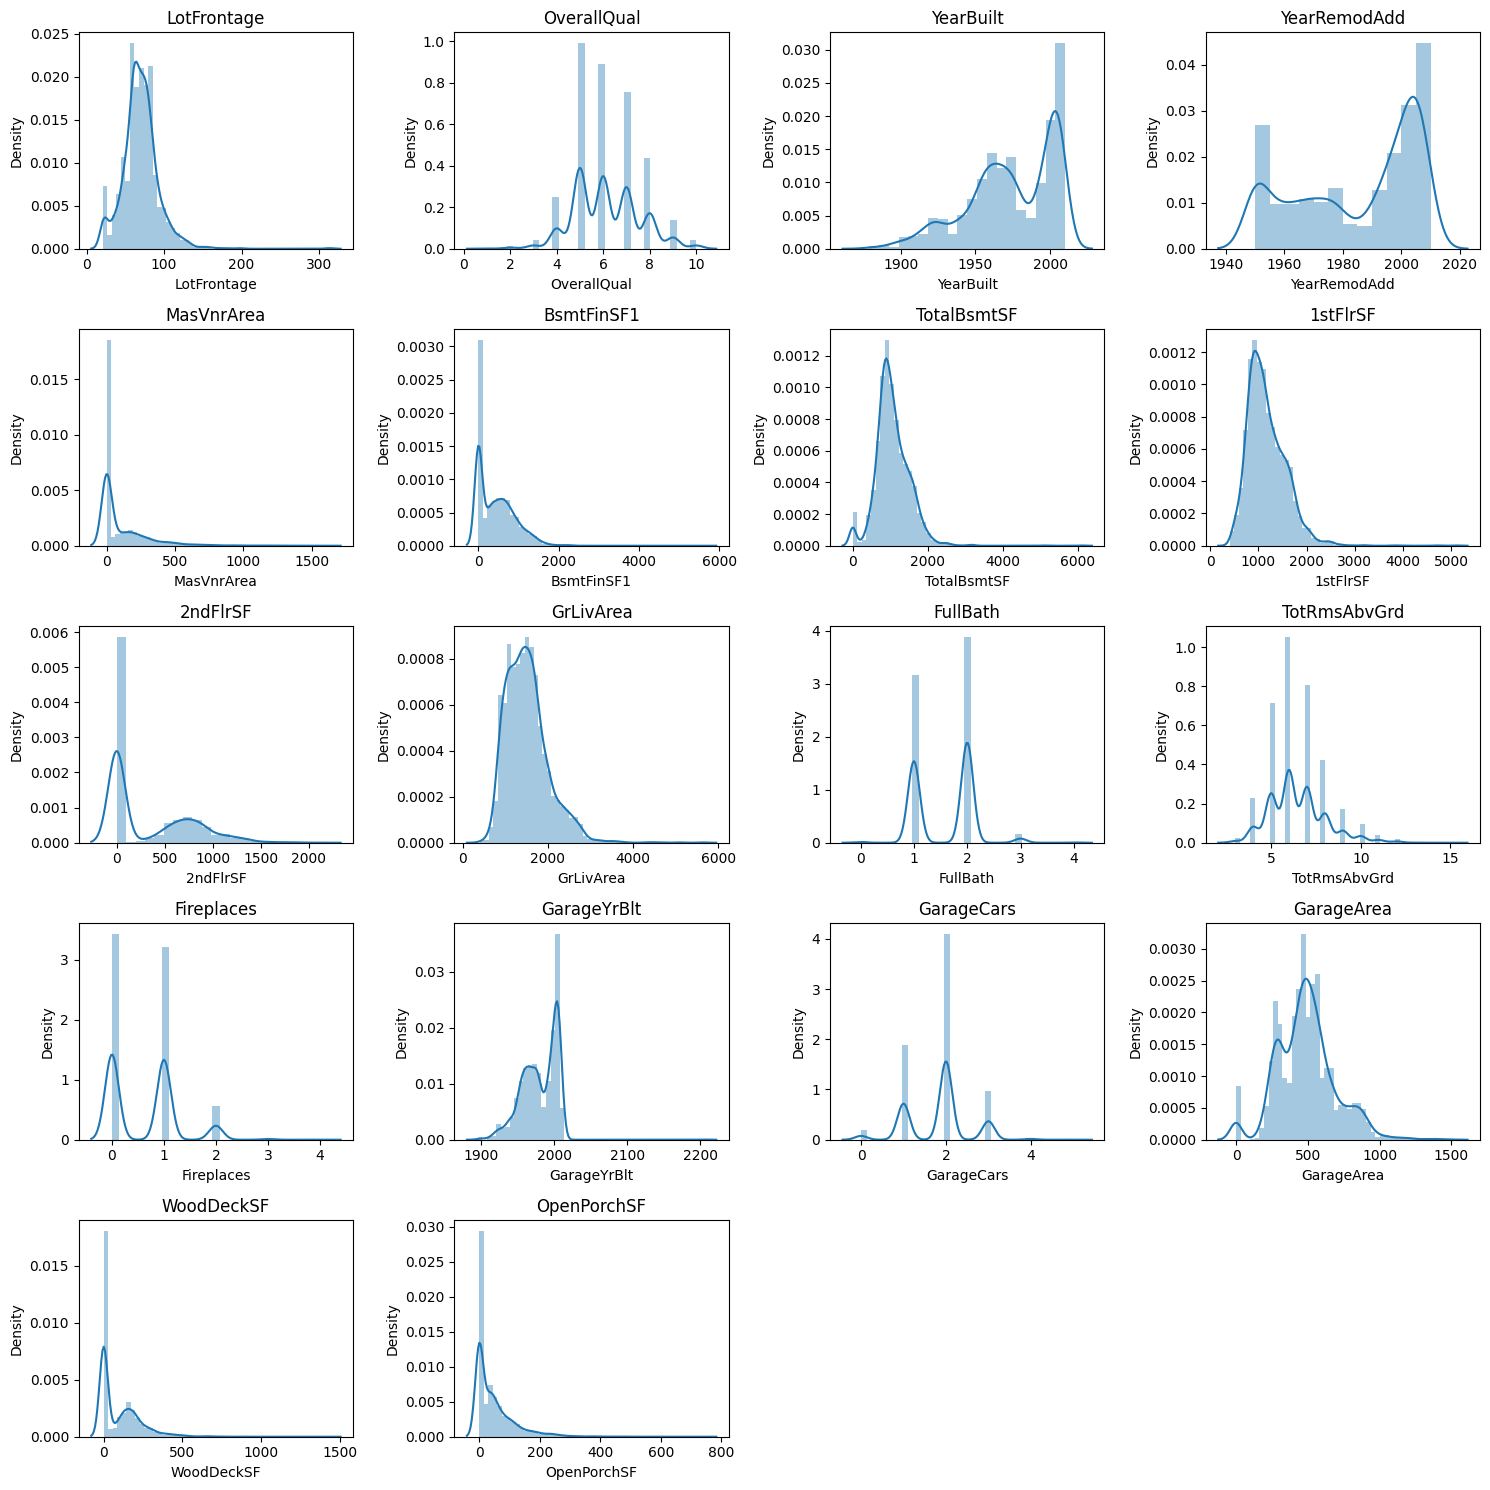

In [11]:
num_data = data.select_dtypes(include=['int', 'float'])
num_cols_per_row = 4

# 計算總行數
num_rows = (len(num_data.columns) // num_cols_per_row) + 1

# 設置 subplot
fig, axes = plt.subplots(num_rows, num_cols_per_row,
                         figsize=(15, 3 * num_rows))

# 平坦化二維陣列
axes = axes.flatten()

# 迭代列並繪製直方圖
for i, column in enumerate(num_data.columns):
    sns.distplot(num_data[column].dropna(), ax=axes[i])
    axes[i].set_title(column)

# 關閉多餘的子圖
for j in range(len(num_data.columns), len(axes)):
    fig.delaxes(axes[j])

# 調整子圖的間距
plt.tight_layout()

# 顯示圖表
plt.show()

運用 K-Nearest-Neighbor的演算法填補數值型缺失值

In [12]:
# 填補缺失值
num_data = data.select_dtypes(include=['int', 'float'])

# 使用 fill_nan_by_knn 函式填補缺失值
data_fill = fill_nan_by_knn(num_data, 3, "skip")

# 覆蓋原始數據中的相應部分
data.loc[:, num_data.columns] = data_fill

對資料中數值型特徵進行標準化，有助於消除不同特徵間的尺度差異，確保模型在訓練過程中更好地收斂，提高預測的準確性

In [13]:
# 數值型特徵標準化
num_data_col = data.select_dtypes(include=['int', 'float']).columns
scaler = StandardScaler()
data[num_data_col] = scaler.fit_transform(data[num_data_col])

1. 觀察類別型特徵，發現有些其實有順序性，故在這裡會把這類型的特徵轉成順序特徵
2. 無順序特徵者，進行one-hot encoding。

In [14]:
# 處理object feature

# lebel encoding
columns_to_fillna = ['ExterQual', 'BsmtQual', 'HeatingQC',
                     'KitchenQual', 'FireplaceQu', 'BsmtExposure', 'BsmtFinType1']

# 使用fillna進行缺失值填充
data[columns_to_fillna] = data[columns_to_fillna].fillna('none')

for i in ['ExterQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu']:
    data[i] = data[i].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'none'], [
                              5, 4, 3, 2, 1, 0]).astype(int)

for i in ['BsmtExposure']:
    data[i] = data[i].replace(['Gd', 'Av', 'Mn', 'No', 'none'], [
                              4, 3, 2, 1, 0]).astype(int)

for i in ['BsmtFinType1']:
    data[i] = data[i].replace(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'none'], [
                              6, 5, 4, 3, 2, 1, 0]).astype(int)

# one-hot encoding
finish_data = pd.get_dummies(data, dtype=int)

## 程式碼目的

這段程式碼的目的是將數據集分為訓練集（x_train, y_train）和測試集（x_test, y_test）。

In [15]:
# split train and validate data　
x = finish_data[:1303]
y = np.array(np.log1p(SalePrice_train))
Test = finish_data[1303:]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.3, random_state=321)

## Ridge Regression 模型建構

這段程式碼的目的是使用 Ridge Regression模型進行房價預測。

### RidgeCV 參數設定

1. **設定 alpha 值：** 事先定義了一組 alpha 值，用於 Ridge Regression 模型的正則化參數。這些 alpha 值的範圍包括 `[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]`。

2. **使用 RidgeCV：** 使用 `RidgeCV` 函數進行 Ridge Regression 模型的建構。設定了 `alphas` 參數為先前定義的 alpha 值，同時使用 5 折交叉驗證（`cv=5`）進行模型評估。

### 模型訓練和預測

3. **模型擬合：** 在訓練集 `x_train` 和目標變數 `y_train` 上擬合 Ridge Regression 模型。

4. **模型預測：** 使用擬合好的模型對訓練集和測試集進行預測，分別得到預測結果 `y_ridge_train` 和 `y_ridge_test`。

### 模型評估

5. **評估模型表現（RMSE）：** 使用 `sklearn.metrics.mean_squared_error` 函數計算模型在訓練集和測試集上的均方根誤差（RMSE），並將結果輸出。

In [16]:
# Ridge regression
# 設定交叉驗證的alpha值
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# 使用RidgeCV進行模型建構，設定交叉驗證(cv=5)
ridge = RidgeCV(alphas=alpha, cv=5)

# 在訓練集上擬合模型
ridge_fit = ridge.fit(x_train, y_train)

# 預測訓練集和測試集
y_ridge_train = ridge_fit.predict(x_train)
y_ridge_test = ridge_fit.predict(x_test)

# 評估模型表現 (RMSE)
print('RMSE_train_Ridge = ' +
      str(math.sqrt(sklm.mean_squared_error(y_train, y_ridge_train))))
print('RMSE_test_Ridge = ' +
      str(math.sqrt(sklm.mean_squared_error(y_test, y_ridge_test))))

RMSE_train_Ridge = 0.11738604446970476
RMSE_test_Ridge = 0.1209536705244321


## Lasso Regression 模型建構

這段程式碼主要是使用 Lasso Regression（套索回歸）模型進行房價預測。以下是程式碼的分析：

### LassoCV 參數設定

1. **設定 alpha 值：** 先定義了一組 alpha 值，用於 Lasso Regression 模型的正則化參數。這裡的 alpha 參數代表正則化項的強度。

2. **使用 LassoCV：** 採用 `LassoCV` 函數進行 Lasso Regression 模型的建構。`alphas` 參數被設定為事先定義的 alpha 值，同時使用 5 折交叉驗證（`cv=5`）進行模型的評估。

### 模型訓練和預測

3. **模型擬合：** 在訓練集 `x_train` 和目標變數 `y_train` 上擬合 Lasso Regression 模型。

4. **模型預測：** 使用擬合好的模型對訓練集和測試集進行預測，得到預測結果 `y_lasso_train` 和 `y_lasso_test`。

### 模型評估

5. **評估模型表現（RMSE）：** 使用均方根誤差（RMSE）評估模型在訓練集和測試集上的性能。`sklearn.metrics.mean_squared_error` 函數被用來計算 RMSE。

In [17]:
# Lasso regression
# 設定交叉驗證的 alpha 值
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# 使用 LassoCV 進行模型建構，設定交叉驗證(cv=5)
Lasso = LassoCV(alphas=alpha, cv=5, max_iter=10000)

# 在訓練集上擬合模型
Lasso_fit = Lasso.fit(x_train, y_train)

# 預測訓練集和測試集的目標值
y_lasso_train = Lasso_fit.predict(x_train)
y_lasso_test = Lasso_fit.predict(x_test)

# 計算並輸出訓練集和測試集的 RMSE
print('RMSE_train_Lasso = ' +
      str(math.sqrt(sklm.mean_squared_error(y_train, y_lasso_train))))
print('RMSE_test_Lasso = ' +
      str(math.sqrt(sklm.mean_squared_error(y_test, y_lasso_test))))

RMSE_train_Lasso = 0.1254249750274729
RMSE_test_Lasso = 0.12041452727106029


## ElasticNet 模型建構

這段程式碼的目的是使用 ElasticNet 模型對數據進行建模，同時進行交叉驗證以選擇最佳的 alpha 和 l1_ratio 參數。以下是程式碼的詳細說明：

### 超參數設定

1. **alpha 和 l1_ratio 設定：** 定義了一組 alpha 和 l1_ratio 參數的範圍，用於進行超參數搜索。`alpha` 表示正則化項的強度，`l1_ratio` 是 L1 正則化的比例。

### ElasticNetCV 模型

2. **ElasticNetCV 模型建構：** 使用 `ElasticNetCV` 類進行模型建構，設定了交叉驗證(cv=5)、最大迭代次數(max_iter=1000000)以及上述定義的 alpha 和 l1_ratio 範圍。

### 模型擬合和預測

3. **模型擬合：** 在訓練集上擬合 ElasticNet 模型，使用交叉驗證選擇最佳的 alpha 和 l1_ratio。

4. **預測：** 利用擬合好的 ElasticNet 模型對訓練集和測試集的目標值進行預測。

### 模型評估

5. **模型評估：** 計算並輸出訓練集和測試集的 RMSE（均方根誤差），以評估模型的預測性能。

In [18]:
# ElasticNet
# set cross-validation alpha and l1ratio
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
l1ratio = [0.1, 0.5, 0.9, 0.95, 0.99, 1]
# find the best alpha/l1ratio and build model
elastic_cv = ElasticNetCV(cv=5, max_iter=1000000,
                          alphas=alpha,  l1_ratio=l1ratio)
elastic_fit = elastic_cv.fit(x_train, y_train)
y_el_train = elastic_fit.predict(x_train)
y_el_test = elastic_fit.predict(x_test)
# validation( train data and validate data)
print('RMSE_train_ElasticNet = ' +
      str(math.sqrt(sklm.mean_squared_error(y_train, y_el_train))))
print('RMSE_test_ElasticNet = ' +
      str(math.sqrt(sklm.mean_squared_error(y_test, y_el_test))))

RMSE_train_ElasticNet = 0.11799167038769287
RMSE_test_ElasticNet = 0.12002636490981955


## 模型建構 (Voting)

這段程式碼的目的是使用投票法（Voting）結合 Ridge Regression、Lasso Regression 和 ElasticNet 三種模型，形成一個整體的預測模型。以下是程式碼的詳細說明：

### 模型構建

1. **VotingRegressor：** 使用 `VotingRegressor` 類進行模型構建，結合了三個模型：Ridge Regression (`Ridge`）、Lasso Regression (`Lasso`) 和 ElasticNet (`Elastic`)。每個模型都有其獨特的特點，結合在一起可以綜合利用它們的優勢。

### 模型擬合和預測

2. **模型擬合：** 在訓練集上擬合投票模型，這意味著每個基模型都在訓練集上進行擬合。

3. **預測：** 利用擬合好的投票模型對訓練集和測試集的目標值進行預測。

### 模型評估

4. **模型評估：** 計算並輸出訓練集和測試集的 RMSE（均方根誤差），以評估整體預測模型的性能。

In [19]:
# Build Model (voting)
vote_mod = VotingRegressor(
    [('Ridge', ridge_fit), ('Lasso', Lasso_fit), ('Elastic', elastic_fit)])
vote = vote_mod.fit(x_train, y_train.ravel())
# predict train/test y
vote_pred_train = vote.predict(x_train)
vote_pred_test = vote.predict(x_test)
# validation( train data and validate data)
print('RMSE_train_Voting = ' +
      str(math.sqrt(sklm.mean_squared_error(y_train, vote_pred_train))))
print('RMSE_test_Voting = ' +
      str(math.sqrt(sklm.mean_squared_error(y_test, vote_pred_test))))

RMSE_train_Voting = 0.11962309181541231
RMSE_test_Voting = 0.11957230006765976


## 模型建構 (Stacking)

這段程式碼的目的是使用堆疊法（Stacking）將 Ridge Regression、Lasso Regression 和 ElasticNet 三個基模型的預測結果作為輸入，再利用 Gradient Boosting Regressor（GBDT）作為元模型進行整體的預測。以下是程式碼的詳細說明：

### 模型構建

1. **GradientBoostingRegressor：** 使用 `GradientBoostingRegressor` 類構建 GBDT 元模型。這是一種集成模型，它可以根據之前模型的預測結果進行更進一步的預測。

2. **StackingRegressor：** 使用 `StackingRegressor` 類構建堆疊模型，其中包括三個基模型：Ridge Regression (`ridge_fit`）、Lasso Regression (`Lasso_fit`) 和 ElasticNet (`elastic_fit`)。元模型選擇了 GBDT。

### 模型擬合和預測

3. **模型擬合：** 在訓練集上擬合堆疊模型，包括基模型和元模型。

4. **預測：** 利用擬合好的堆疊模型對訓練集和測試集的目標值進行預測。

### 模型評估

5. **模型評估：** 計算並輸出訓練集和測試集的 RMSE（均方根誤差），以評估整體堆疊模型的性能。

In [20]:
# stack
gbdt = GradientBoostingRegressor(learning_rate=0.05,
                                 max_leaf_nodes=3,
                                 n_estimators=100)
stregr = StackingRegressor(regressors=[ridge_fit, Lasso_fit, elastic_fit],
                           meta_regressor=gbdt,
                           use_features_in_secondary=True)
stack_mod = stregr.fit(x_train, y_train.ravel())
# predict train/test y
stacking_pred_train = stack_mod.predict(x_train)
stacking_pred_test = stack_mod.predict(x_test)
# # validation( train data and validate data)
print('RMSE_train_Stacking = ' +
      str(math.sqrt(sklm.mean_squared_error(y_train, stacking_pred_train))))
print('RMSE_test_Stacking = ' +
      str(math.sqrt(sklm.mean_squared_error(y_test, stacking_pred_test))))

RMSE_train_Stacking = 0.10138388200018193
RMSE_test_Stacking = 0.11869207634048319


c:\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(


## 混和模型權重設定

這段程式碼的目的是設定權重列表，然後使用不同的權重值對 Voting 和 Stacking 兩個模型的預測結果進行混和，計算不同混和權重下的訓練集和測試集的 RMSE（均方根誤差）。以下是程式碼的詳細說明：

### 混和模型

1. **權重列表：** 使用 `np.linspace` 生成一個包含 0.1 到 1 之間的 91 個權重值的列表。

2. **初始化結果列表：** 創建一個空的列表 `blending_results` 用於存儲混和結果。

3. **混和模型：** 使用迴圈遍歷不同的權重值，分別計算 Voting 和 Stacking 兩個模型的混和預測結果。

4. **RMSE 計算：** 使用 `sklm.mean_squared_error` 計算每個混和模型在訓練集和測試集上的 RMSE。

5. **結果儲存：** 將每個混和模型的權重值、訓練集 RMSE 和測試集 RMSE 存入 `blending_results` 列表中。

### 結果輸出

6. **資料框轉換：** 將 `blending_results` 轉換成 Pandas 資料框。

7. **輸出前 10 個最低 RMSE 的權重值

In [21]:
# blend
# 設定權重列表
weights = np.linspace(0.1, 1, 91)

# 初始化結果列表
blending_results = []

# 使用不同權重進行混合，計算訓練集和測試集的 RMSE
for weight in weights:
    blending_pred_train = weight * vote_pred_train + \
        (1 - weight) * stacking_pred_train
    blending_pred_test = weight * vote_pred_test + \
        (1 - weight) * stacking_pred_test
    train_rmse = math.sqrt(sklm.mean_squared_error(
        y_train, blending_pred_train))
    test_rmse = math.sqrt(sklm.mean_squared_error(y_test, blending_pred_test))
    blending_results.append(
        {'weight': weight, 'train_rmse': train_rmse, 'test_rmse': test_rmse})

# 轉換成資料框
blending_output = pd.DataFrame(blending_results)

# 輸出前 10 個具有最低測試集 RMSE 的權重值
top_10_weights = blending_output.sort_values(by='test_rmse').head(10)
print(top_10_weights)

    weight  train_rmse  test_rmse
29    0.39    0.106384   0.118104
28    0.38    0.106219   0.118104
30    0.40    0.106551   0.118105
27    0.37    0.106055   0.118105
31    0.41    0.106720   0.118106
26    0.36    0.105894   0.118107
32    0.42    0.106891   0.118108
25    0.35    0.105734   0.118109
33    0.43    0.107064   0.118111
24    0.34    0.105576   0.118113


# predict and blending
# 最終預測
final_pred_voting = vote.predict(Test)
final_pred_stacking = stack_mod.predict(Test)
final_pred_blending = 0.4 * final_pred_voting + 0.6 * final_pred_stacking

# 反轉 log(y)
final_pred_blending = np.expm1(final_pred_blending)

# 創建提交的資料框
submit = pd.DataFrame({'Id': range(1461, 2920, 1),
                       'SalePrice': final_pred_blending})
# 儲存為 CSV
submit.to_csv('submit.csv', index=False)

In [22]:
# predict and blending
# 最終預測
final_pred_voting = vote.predict(Test)
final_pred_stacking = stack_mod.predict(Test)
final_pred_blending = 0.4 * final_pred_voting + 0.6 * final_pred_stacking

# 反轉 log(y)
final_pred_blending = np.expm1(final_pred_blending)

# 創建提交的資料框
submit = pd.DataFrame({'Id': range(1461, 2920, 1),
                       'SalePrice': final_pred_blending})
# 儲存為 CSV
submit.to_csv('submit.csv', index=False)

c:\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
